In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

In [79]:
x_train, x_valid, y_train, y_valid = get_siso_data(
    n=10000,
    colored_noise=True,
    sigma=0.0001,
    train_percentage=90)

In [94]:
data = pd.read_csv('data/ewa.txt', header=None)
data = data[[2,4]]
data = data.drop_duplicates()[:1300]
data[2] = (data[2]-data[2].mean())/data[2].std()
data[4] = (data[4]-data[4].mean())/data[4].std()
data.to_csv('data/ewa.csv', index=False, header=False)

In [95]:

with open('data/ewa.csv','r') as f:
    data = np.loadtxt(f,delimiter=',')
    
n_cols = data.shape[0]
p = 0.5
x_train, x_valid = data[:int(n_cols*0.8),0].reshape(-1,1), data[int(n_cols*p):,0].reshape(-1,1)
y_train, y_valid = data[:int(n_cols*0.8),1].reshape(-1,1), data[int(n_cols*p):,1].reshape(-1,1)

In [96]:
basis_function = Polynomial(degree=3)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=5,
    xlag=5,
    elag=5,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

In [97]:
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_train, y=y_train)
print(mean_squared_error(y_train, yhat))

yhat = model.predict(X=x_valid, y=y_valid)
print(mean_squared_error(y_valid, yhat))

2.2402717726134185
2.0258482654552483


In [98]:
pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='dec'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])

,Regressors,Parameters,ERR
0,y(k-1),1.1813,0.64947766
1,y(k-2)^3,-0.1901,0.11110898
2,x1(k-5)y(k-2)^2,-0.0574,0.00757139
3,y(k-3)y(k-1)^2,0.1835,0.00731122
4,y(k-1)^3,-0.1429,0.01260428
5,y(k-5)y(k-2),0.1026,0.00740842
6,y(k-5)y(k-4)y(k-3),-0.0502,0.00357519
7,x1(k-1)y(k-4)^2,0.0452,0.00193959
8,x1(k-2)y(k-5)y(k-2),-0.0583,0.00167425
9,y(k-2)y(k-1),-0.0419,0.00195732


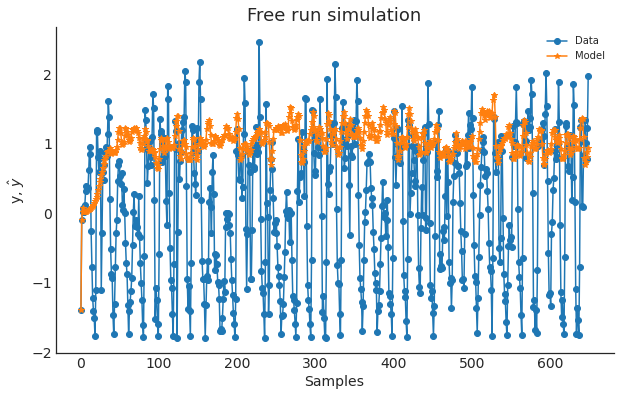

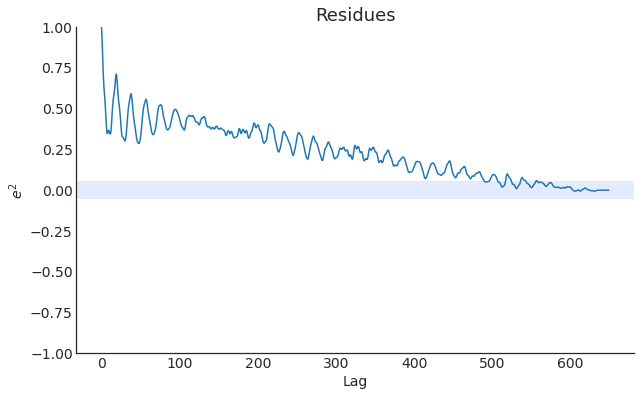

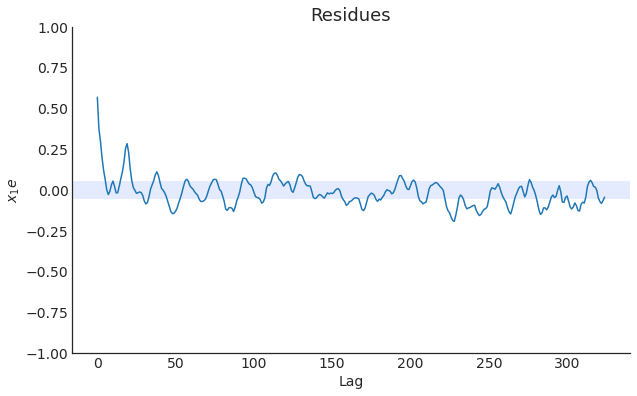

In [99]:
plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")